# 3D analysis

This tutorial does a 3D map based analsis on the galactic center, using simulated observations from the CTA-1DC. We will use the high level interface for the data reduction, and then do a detailed modelling. This will be done in two different ways:

- stacking all the maps together and fitting the stacked maps
- handling all the observations separately and doing a joint fitting on all the maps

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
from pathlib import Path
from regions import CircleSkyRegion
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.modeling.models import (
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
)
from gammapy.modeling import Fit
from gammapy.maps import Map

## Analysis configuration

In this section we select observations and define the analysis geometries, irrespective of  joint/stacked analysis. For configuration of the analysis, we will programatically build a config file from scratch.

In [ ]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

In [ ]:
# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

In [ ]:
# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.fov = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV offset cut
config.datasets.geom.selection.offset_max = 3.5 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true enery binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

In [ ]:
print(config)

## Configuration for stacked and joint analysis

This is done just by specfiying the flag on `config.datasets.stack`. Since the internal machinery will work differently for the two cases, we will write it as two config files and save it to disc in YAML format for future reference. 

In [ ]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

In [ ]:
# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_joint.write(path=path / "config_joint.yaml", overwrite=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)

## Stacked analysis

### Data reduction

We first show the steps for the stacked analysis and then repeat the same for the joint analysis later


In [ ]:
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")

In [ ]:
analysis_stacked = Analysis(config_stacked)

In [ ]:
%%time
# select observations:
analysis_stacked.get_observations()

# run data reduction
analysis_stacked.get_datasets()

We have one final dataset, which you can print and explore

In [ ]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

In [ ]:
# To plot a smooth counts map
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

In [ ]:
# And the background map
dataset_stacked.background_model.map.plot_interactive(add_cbar=True)

In [ ]:
# You can also get an excess image with a few lines of code:
counts = dataset_stacked.counts.sum_over_axes()
background = dataset_stacked.background_model.map.sum_over_axes()
excess = counts - background
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True);

### Modeling and fitting

Now comes the interesting part of the analysis - choosing appropriate models for our source and fitting them.

We choose a point source model with an exponential cutoff power-law spectrum.

To select a certain energy range for the fit we can create a fit mask:

In [ ]:
coords = dataset_stacked.counts.geom.get_coord()
mask_energy = coords["energy"] > 0.3 * u.TeV
dataset_stacked.mask_fit = Map.from_geom(
    geom=dataset_stacked.counts.geom, data=mask_energy
)

In [ ]:
spatial_model = PointSpatialModel(
    lon_0="-0.05 deg", lat_0="-0.05 deg", frame="galactic"
)
spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

dataset_stacked.models = model
dataset_stacked.background_model.norm.value = 1.3

In [ ]:
%%time
fit = Fit([dataset_stacked])
result = fit.run(optimize_opts={"print_level": 1})

In [ ]:
result.parameters.to_table()

### Check model fit

We check the model fit by computing and plotting a residual image:

In [ ]:
dataset_stacked.plot_residuals(method="diff/sqrt(model)", vmin=-1, vmax=1)

We can also plot the best fit spectrum. For that need to extract the covariance of the spectral parameters.

## Joint analysis

In this section, we perform a joint analysis of the same data. Of course, joint fitting is considerably heavier than stacked one, and should always be handled with care. For brevity, we only show the analysis for a point source fitting without re-adding a diffuse component again. 

### Data reduction

In [ ]:
%%time

# Read the yaml file from disk
config_joint = AnalysisConfig.read(path=path / "config_joint.yaml")
analysis_joint = Analysis(config_joint)

# select observations:
analysis_joint.get_observations()

# run data reduction
analysis_joint.get_datasets()

In [ ]:
# You can see there are 3 datasets now
print(analysis_joint.datasets)

In [ ]:
# You can access each one by name or by index, eg:
print(analysis_joint.datasets[0])

In [ ]:
# Add the model on each of the datasets
model_joint = model.copy()
for dataset in analysis_joint.datasets:
    dataset.models = model_joint
    dataset.background_model.norm.value = 1.1

In [24]:
%%time
fit_joint = Fit(analysis_joint.datasets)
result_joint = fit_joint.run()

CPU times: user 25.5 s, sys: 9.74 s, total: 35.3 s
Wall time: 39.9 s


In [25]:
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 183
	total stat : 326615.82



In [26]:
fit_joint.datasets.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,-5.246e-02,nan,deg,nan,nan,False
lat_0,-5.246e-02,nan,deg,-9.000e+01,9.000e+01,False
index,2.290e+00,nan,,nan,nan,False
amplitude,2.907e-12,nan,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,nan,TeV,nan,nan,True
lambda_,3.267e-02,nan,TeV-1,nan,nan,False
alpha,1.000e+00,nan,,nan,nan,True
norm,1.113e+00,nan,,0.000e+00,nan,False
tilt,0.000e+00,nan,,nan,nan,True


The information which parameter belongs to which dataset is not listed explicitly in the table (yet), but the order of parameters is conserved. You can always access the underlying object tree as well to get specific parameter values:

In [27]:
for dataset in analysis_joint.datasets:
    print(dataset.background_model.norm.value)

1.1126992883175837
1.1163307844391888
1.1087952750153587


### Residuals

Since we have multiple datasets, we can either look at a stacked residual map, or the residuals for each dataset. Each `gammapy.cube.MapDataset` object is equipped with a method called `gammapy.cube.MapDataset.plot_residuals()`, which displays the spatial and spectral residuals (computed as *counts-model*) for the dataset. Optionally, these can be normalized as *(counts-model)/model* or *(counts-model)/sqrt(model)*, by passing the parameter `norm='model` or `norm=sqrt_model`.

In [28]:
# To see the spectral residuals, we have to define a region for the spectral extraction
region = CircleSkyRegion(spatial_model.position, radius=0.15 * u.deg)

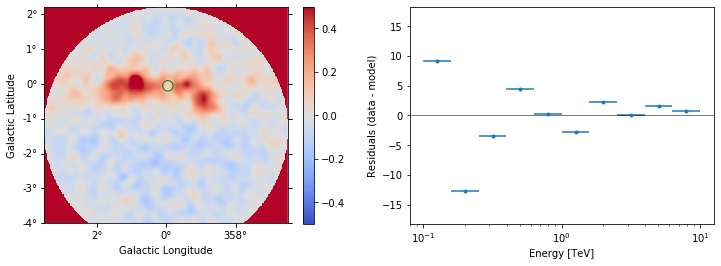

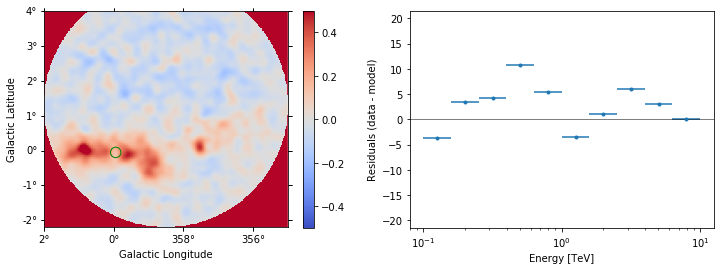

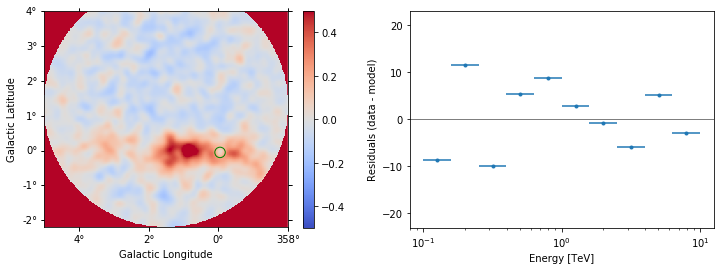

In [29]:
for dataset in analysis_joint.datasets:
    ax_image, ax_spec = dataset.plot_residuals(
        region=region, vmin=-0.5, vmax=0.5, method="diff"
    )

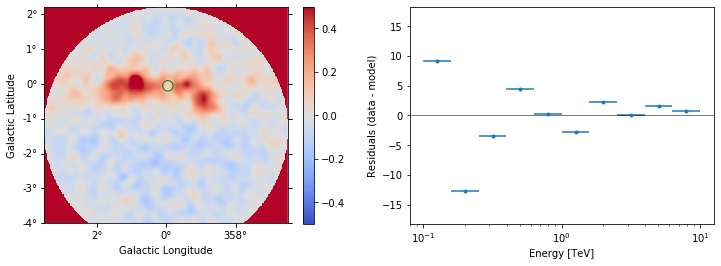

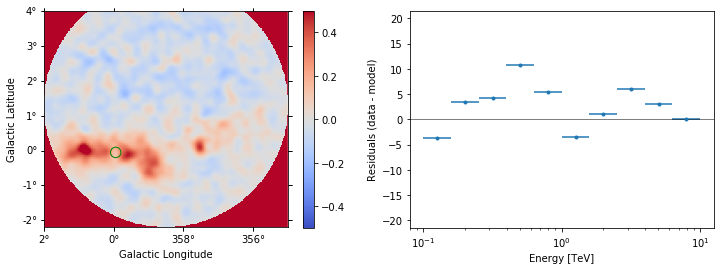

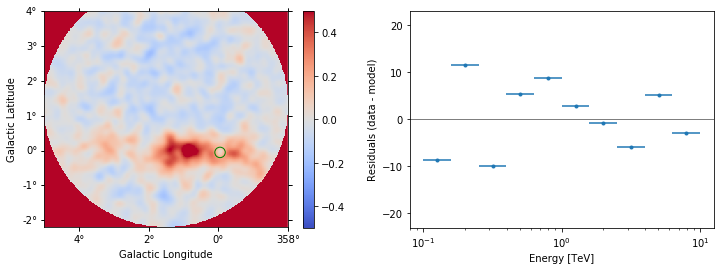

In [30]:
for dataset in analysis_joint.datasets:
    ax_image, ax_spec = dataset.plot_residuals(
        region=region, vmin=-0.5, vmax=0.5, method="diff"
    )

In [31]:
# We need to stack on the full geometry, so we use to geom from the stacked counts map.
residuals_stacked = Map.from_geom(analysis_stacked.datasets[0].counts.geom)

for dataset in analysis_joint.datasets:
    residuals = dataset.residuals()
    residuals_stacked.stack(residuals)

residuals_stacked.sum_over_axes().smooth("0.08 deg").plot(
    vmin=-1, vmax=1, cmap="coolwarm", add_cbar=True, stretch="linear"
);

Error in callback <function flush_figures at 0x10c967ae8> (for post_execute):


KeyboardInterrupt: 

Finally let us compare the spectral results from the stacked and joint fit:

In [32]:
def plot_spectrum(model, result, label):
    spec = model.spectral_model

    # set covariance on the spectral model
    covar = result.parameters.get_subcovariance(spec.parameters)
    spec.parameters.covariance = covar

    energy_range = [0.3, 10] * u.TeV
    spec.plot(energy_range=energy_range, energy_power=2, label=label)
    spec.plot_error(energy_range=energy_range, energy_power=2)

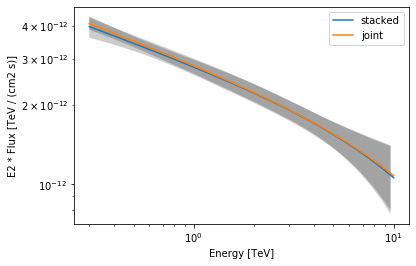

In [33]:
plot_spectrum(model, result, label="stacked")
plot_spectrum(model_joint, result_joint, label="joint")
plt.legend()

## Summary

Note that this notebook aims to show you the procedure of a 3D analysis using just a few observations. Results get much better for a more complete analysis considering the GPS dataset from the CTA First Data Challenge (DC-1) and also the CTA model for the Galactic diffuse emission, as shown in the next image:

![](images/DC1_3d.png)

The complete tutorial notebook of this analysis is available to be downloaded in [GAMMAPY-EXTRA](https://github.com/gammapy/gammapy-extra) repository at https://github.com/gammapy/gammapy-extra/blob/master/analyses/cta_1dc_gc_3d.ipynb).

## Exercises

* Analyse the second source in the field of view: G0.9+0.1 and add it to the combined model.
* Perform modeling in more details - Add diffuse component, get flux points.